In [2]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np
import keras

2024-04-26 15:30:19.774348: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 15:30:19.774506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 15:30:19.830303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 15:30:19.960656: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 15:30:21.041435: W tensorflow/compiler/tf2

In [3]:
# Create list of all targets
dataset_path = '/home/pmedur/strojnoUcenje/env/bin/TorchAudio/SpeechCommands/speech_commands_v0.02'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
all_targets.remove('.ipynb_checkpoints')
print(all_targets)

['stop', 'up', 'learn', 'bird', 'follow', 'wow', 'on', 'marvin', 'tree', 'no', 'dog', 'happy', 'off', 'down', 'six', 'sheila', 'bed', 'seven', 'visual', 'four', 'right', 'five', 'cat', 'house', 'left', 'go', 'eight', 'forward', 'one', 'yes', 'two', 'backward', 'nine', 'three', 'zero']


In [4]:
# Settings
feature_sets_path = '/home/pmedur/strojnoUcenje/env/bin/Tensorflow_speech_recognition/tflite-speech-recognition-master'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_stop_model.h5'
wake_word = 'on'

In [5]:
# Loading feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [6]:
# Assigning feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [7]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77494, 16, 16)
(9692, 16, 16)
(9670, 16, 16)


In [8]:
print(y_val)

[32. 25.  1. ... 13. 34.  1.]


In [9]:
# Converting ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [10]:
# Percentage of 'go' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.03342963268675196
0.9665703673132481


In [11]:
# CNN for TF expects (batch, height, width, channels)
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)

In [14]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [15]:
# CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

2024-04-14 16:17:57.032034: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-04-14 16:17:57.032067: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: pmedur-MS-7978
2024-04-14 16:17:57.032078: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: pmedur-MS-7978
2024-04-14 16:17:57.032200: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.171.4
2024-04-14 16:17:57.032233: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.161.7
2024-04-14 16:17:57.032242: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 535.161.7 does not match DSO version 535.171.4 -- cannot find working devices in this configuration


In [16]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          4128      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 64)          0

In [26]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

In [27]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30


2024-04-14 17:09:10.698316: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 79353856 exceeds 10% of free system memory.


775/775 [==============================] - 5s 6ms/step - loss: 0.0393 - acc: 0.9872 - val_loss: 0.0468 - val_acc: 0.9832
Epoch 2/30
775/775 [==============================] - 4s 6ms/step - loss: 0.0361 - acc: 0.9874 - val_loss: 0.0413 - val_acc: 0.9858
Epoch 3/30
775/775 [==============================] - 5s 6ms/step - loss: 0.0339 - acc: 0.9879 - val_loss: 0.0419 - val_acc: 0.9874
Epoch 4/30
775/775 [==============================] - 4s 6ms/step - loss: 0.0337 - acc: 0.9884 - val_loss: 0.0359 - val_acc: 0.9879
Epoch 5/30
775/775 [==============================] - 4s 6ms/step - loss: 0.0309 - acc: 0.9891 - val_loss: 0.0452 - val_acc: 0.9847
Epoch 6/30
775/775 [==============================] - 5s 6ms/step - loss: 0.0296 - acc: 0.9897 - val_loss: 0.0401 - val_acc: 0.9872
Epoch 7/30
775/775 [==============================] - 5s 6ms/step - loss: 0.0296 - acc: 0.9897 - val_loss: 0.0356 - val_acc: 0.9888
Epoch 8/30
775/775 [==============================] - 5s 6ms/step - loss: 0.0279 - acc:

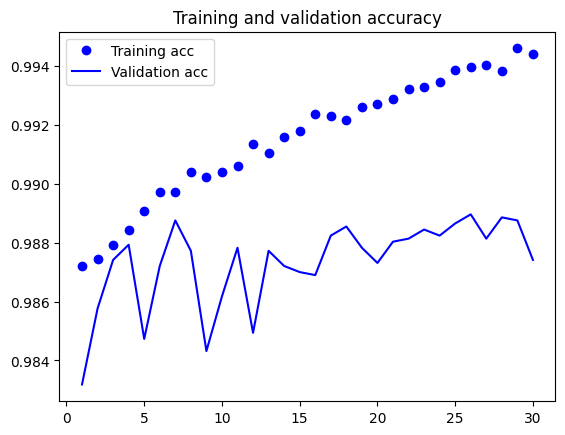

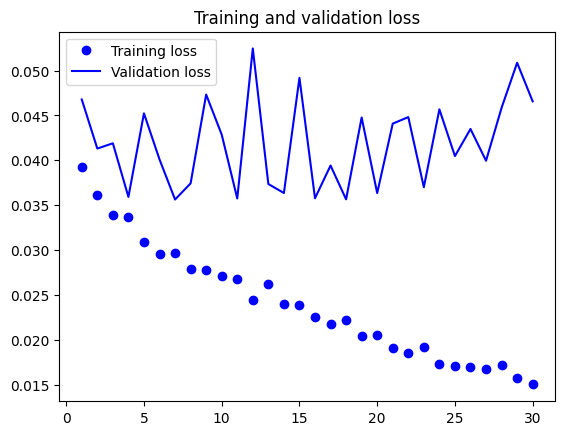

In [28]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
models.save_model(model, model_filename)

/tmp/ipykernel_4680/4025196136.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  models.save_model(model, model_filename)


In [21]:
# See which are 'go'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

9
34
146
147
154
172
176
184
193
196
246
248
273
304
323
333
334
338
381
393
454
464
550
559
580
639
677
688
707
729
778
779
798
806
813
814
819
839
862
874
885
994
1002
1010
1042
1071
1091
1118
1183
1200
1222
1230
1289
1297
1355
1402
1403
1482
1500
1517
1549
1610
1613
1645
1669
1702
1709
1769
1781
1794
1818
1823
1858
1871
1875
1881
1883
1886
1924
1980
1987
2007
2019
2020
2070
2098
2129
2160
2174
2192
2229
2242
2294
2314
2371
2387
2409
2430
2440
2468
2469
2615
2630
2638
2652
2691
2708
2710
2724
2733
2739
2790
2795
2822
2842
2846
2864
2868
2917
2924
2956
2959
3019
3030
3065
3074
3146
3157
3161
3193
3264
3269
3272
3285
3290
3317
3353
3359
3381
3403
3409
3459
3468
3484
3563
3570
3575
3630
3639
3698
3700
3702
3717
3744
3837
3869
3893
3922
3939
3941
3953
3964
4005
4042
4055
4087
4134
4166
4175
4186
4220
4234
4245
4261
4280
4363
4364
4405
4418
4512
4524
4547
4565
4571
4574
4591
4601
4606
4626
4636
4656
4696
4700
4754
4805
4809
4826
4827
4839
4859
4919
4942
5019
5069
5088
5095
5121
5124
5166


In [22]:
# Loading model and run it against test set
model = models.load_model(model_filename)
for i in range(0, 100):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

1/1 [==============================] - 0s 63ms/step
Answer: 0.0  Prediction: [[0.00335173]]
1/1 [==============================] - 0s 12ms/step
Answer: 0.0  Prediction: [[2.726532e-08]]
1/1 [==============================] - 0s 12ms/step
Answer: 0.0  Prediction: [[2.0419652e-23]]
1/1 [==============================] - 0s 12ms/step
Answer: 0.0  Prediction: [[3.8995215e-10]]
1/1 [==============================] - 0s 12ms/step
Answer: 0.0  Prediction: [[2.53151e-11]]
1/1 [==============================] - 0s 13ms/step
Answer: 0.0  Prediction: [[8.0017635e-08]]
1/1 [==============================] - 0s 12ms/step
Answer: 0.0  Prediction: [[8.900022e-16]]
1/1 [==============================] - 0s 12ms/step
Answer: 0.0  Prediction: [[0.32001778]]
1/1 [==============================] - 0s 12ms/step
Answer: 0.0  Prediction: [[1.0900371e-12]]
1/1 [==============================] - 0s 12ms/step
Answer: 1.0  Prediction: [[0.07235271]]
1/1 [==============================] - 0s 12ms/step
Answer: 0.0

In [23]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

303/303 [==============================] - 0s 1ms/step - loss: 0.0787 - acc: 0.9813


[0.07869110256433487, 0.9812822937965393]

In [30]:
#Test: TF lite model
#interpreter = tf.lite.Interpreter('/home/pmedur/strojnoUcenje/env/bin/Tensorflow_speech_recognition/tflite-speech-recognition-master/wake_word_stop_lite.tflite')

#interpreter.allocate_tensors()

# Get input and output tensors.
#input_details = interpreter.get_input_details()
#output_details = interpreter.get_output_details()

#input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
#interpreter.set_tensor(input_details[0]['index'], input_data)

#interpreter.invoke()


#output_data = interpreter.get_tensor(output_details[0]['index'])
#print(output_data)

[[0.00439723]]
